In [38]:
# import libraries
import torch
import torch.nn as nn
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader,TensorDataset

## Regularization

- Penalizes memorization of exaples
- Helps model generalize on unseen data.
- Changes the representation of learning(either more sparse or more distributed depending on regularizer)


### Observation with Regularization
- Can increase or decrease the training time.
- Can decrease training accuracy but increase generalization.
- Works better with complex models.
- Workes better with large datasets

### Family of Regularizer

1. **Node Regularization** : Modify the Model - Dropout
2. **Loss Regularization** : Add cost to Loss Function - L1/L2
3. **Data Regularization** : Modify or add data : Batch training, data augmentation


### What regularization does
- Add cost to complexity of model.
- Forces the solution to be smooth
- Prevents model from learning item-specific details.

### When to use which regularizer
- Depends - often its architecture specific
- Mostly seen different regularizer works equally well.

## Train vs Evaluation Model

- Gradient is computed only during back-prop not during evaluation.
- Some Regularization is applied **only during training**, and not during evaluation.

i.e we need a way to **deactivate gradient computation and regularization** while evaluating model performance.


- **net.train()**  : training mode |  regularization is active
- **net.eval()** : test mode | regularization is turned off
- **torch.no_grad()** : used in test mode |  gradient is not computed

<br>

```python
training epoch loop:
    net.train()

    # train the model
    batch loop:


    # evaluate the model
    net.eval()
    with torch.no_grad():
        yhat = net(x)
```



### Create Data

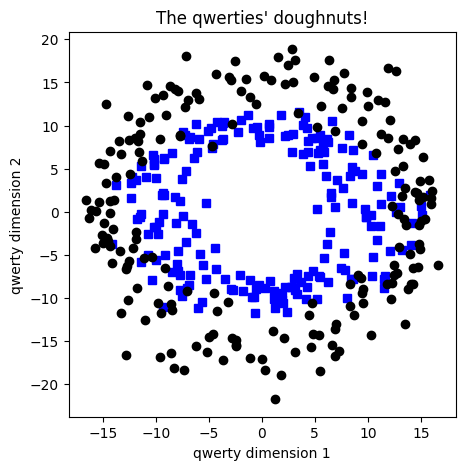

In [39]:
# create data

nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

### Data Loaders

In [40]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# Data Loader
batch_size = 16
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

test_data = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True
)

### DropOut : How it works

DropOut reduces the overall activation(fewer elements in weighted sums).

Solutions:
1. Scale up the weight during training. (Pytorch does this)
2. Scale Down the weights during testing. 

Effects
- Prevents the single node from learning too much.
- Forces the model to have distributed representations.
- Makes the model less reliant on individual nodes and thus more stable

Observation
- Takes more train epochs(though each epoch run will be bit faster).
- Can decrease training accuracy by increases generalization.
- Ususally better on deep networks.
- Good for when have sufficient data.

In [41]:
# define a dropout instance and make some data
prob = .5

dropout = nn.Dropout(p=prob)
x = torch.ones(10)

# let's see what dropout returns
y = dropout(x)
print(x)
print(y*(1-prob))
print(torch.mean(y))


# dropout is turned off when evaluating the model
print("\n\nTurn Off Dropout")
dropout.eval()
y = dropout(x)   #F.dropout(x,training=False)   (import d torch.nn.functional as F)
print(y)
print(torch.mean(y))
     

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 0., 1., 0., 0., 1., 1., 0., 1.])
tensor(1.2000)


Turn Off Dropout
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


### DropOut in Practice

In [42]:
import torch.nn.functional as F

class DropoutModel(nn.Module):
    def __init__(self,dropout_prob):
        super().__init__()

        self.input = nn.Linear(2,128)
        self.hidden1 = nn.Linear(128,128)
        self.output = nn.Linear(128,1)
        self.dropout_prob = dropout_prob

    def forward(self,x):
        x = F.relu(self.input(x))

        x = F.dropout(x, p =self.dropout_prob,training=self.training)

        x = F.relu(self.hidden1(x))

        x = F.dropout(x, p =self.dropout_prob,training=self.training)

        x = self.output(x)

        return x

In [43]:
def createNetwork(dropout_prob):
    model = DropoutModel(dropout_prob)
    

    loss_fun = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    return model, loss_fun, optimizer

In [44]:
train_acc = []
test_acc = []

epochs = 1000


model, loss_fun, optimizer = createNetwork(prob)
for i in range(epochs):
    # Swithch to training mode
    model.train()

    # loop over the training batches
    batchAcc = []
    for x,y in train_loader:
        yhat = model(x)
        loss = loss_fun(yhat,y)
        
        # Backpropogate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batchAcc.append(100*torch.mean(((yhat>0)==y).float()).item())

    train_acc.append(np.mean(batchAcc))

    # Switch to evaluation mode
    model.eval()

    yhat_test = model(test_data.dataset.tensors[0])
    loss_test = loss_fun(yhat_test,test_data.dataset.tensors[1])
    test_acc.append(100*torch.mean(((yhat_test>0)==test_data.dataset.tensors[1]).float()).item())


In [45]:
# create a 1D smoothing filter
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')

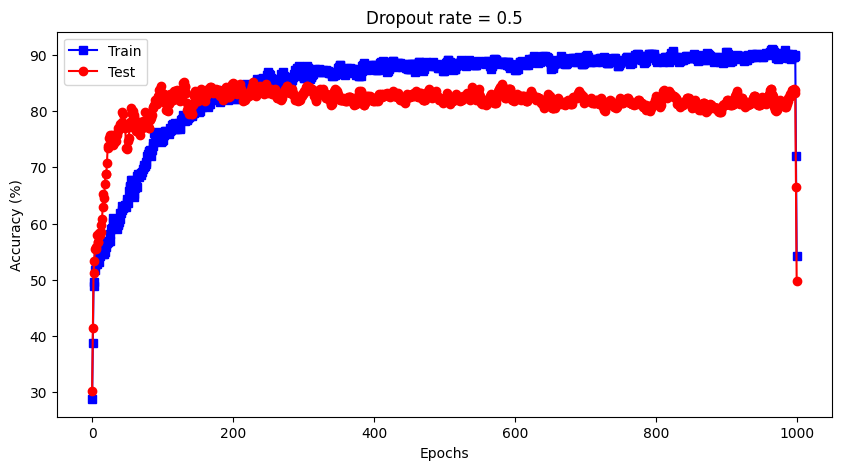

In [63]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(smooth(train_acc),'bs-')
plt.plot(smooth(test_acc),'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%prob)

plt.show()

### L1/L2 Regularizer